In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Proof-of-Concept: Pretraining Language Models with Predicted and Fully Frozen Token Embedding Weights
# &
# Progressive Growth Transformers (PGT)

This notebook and accompanying code present a systematic empirical study of large language models (LLMs) trained with **predicted and entirely frozen input embedding weights** throughout the entire training phase. 

The key goal of this work is to demonstrate, as a proof-of-concept, that it is possible to train powerful transformer-based language models even when the token embedding matrix is:
- **not initialized randomly or pretrained in the standard way**
- but is instead **pre-computed by external means** (in our case: using Unicode visual features, subword patterns, or aggregated token text features)
- and **remains absolutely frozen during all of training and finetuning**

## Experimental Setup

- **Pretrain dataset:** 9 billion tokens sampled from diverse English, Russian, and Chinese corpora (including Wikipedia, SQuAD_v2, TriviaQA, HotpotQA, NQ-Open, BoolQ, CommonsenseQA, AI2 ARC).
- **Model architectures:** Transformer models trained with frozen predicted embeddings as well as baseline models with learnable (standard) embeddings. All other hyperparameters and datasets are equivalent.
- **SFT ("instruction-tuning") data:** Only ~10% of the pretraining batches included SFT-style examples. The models remain primarily pretraining LMs, not instruction-tuned models.
- **Frozen embeddings:** The token embeddings were constructed from external sources and kept frozen for 100% of pretraining and evaluation.
- **Unfrozen baselines:** For comparison, models were trained from identical data with fully learnable embeddings in the classic manner.

## Scientific Contribution

The core scientific value of these experiments is to **provide the first strong empirical demonstration** that:
- Large transformer LMs can learn and generalize even if the input embedding space contains no semantic or distributional information and is not updated during training;
- The higher-level semantic and abstraction capabilities emerge in the transformer layers themselves, not primarily in the learned embedding table;
- The gap in performance between frozen, predicted-embedding models and conventional (baseline) LMs is nonzero but limited, which has ramifications for modularity, model merging/fusion, and scaling.

To our knowledge, **this is the first large-scale direct comparison of fully-frozen, externally-predicted embeddings vs. standard learnable embeddings on a modern LLM pretrain task** with all other factors held equal.

These models are **pretrain-only** (not strong SFT/instruction-tuned LMs). 
Downstream/benchmarked metrics such as BLEU, MMLU, ARC, etc., should be interpreted accordingly: as indications of base model potential, **not as the upper bound of possible finetuned or instruction-following performance**.

For context: Performance metrics of our frozen-embedding LMs are broadly comparable to strong GPT-2-class (100M–400M) baselines under similar pretrain-only settings.

## What this is **not:**
- Not a claim for SOTA on any downstream task.
- Not an argument that no further improvement is possible with more compute or advanced tricks.
- Not a replacement for full SFT/finetuning in LLM pipelines.

## What this **is:**  
**A proof-of-concept and key ablation establishing that high-capacity LMs can learn to encode language and world knowledge using only externally-predicted, fully-frozen token embeddings.**

**All code, models, and metrics are provided for community validation and further research.**



# Progressive Growth Transformers (PGT) 

Progressive Growth Transformers (PGT) series, designed to explore how linguistic and reasoning capabilities emerge as a function of model depth.

This model ('abs-bvv-6') was not trained monolithically. Instead, it was "grown" constructively, one layer at a time, upon a foundation of frozen, non-semantic visual embeddings ('abs-bvv-1'-> 'abs-bvv-2' -> 'abs-bvv-3' -> 'abs-bvv-4' -> 'abs-bvv-5' -> 'abs-bvv-6') 

The core idea is to demonstrate an alternative, more modular and resource-efficient paradigm for building LLMs. The PGT series shows that:

- Semantic understanding can emerge without trainable embeddings.
- Complex reasoning abilities are a direct result of compositional depth.
- Models can be built incrementally, much like a living organism grows, rather than being forged all at once.

In [20]:
prefixes = ['abs-bvv-1',
            'abs-bvv-2',
            'abs-bvv-3',
            'abs-bvv-4',
            'abs-bvv-5',
            'abs-bvv-6',
           ]

In [3]:
results_folder = './' # '_results/'

In [4]:
files = [f for f in os.listdir(results_folder)
         if any(f.endswith(fix+'.txt') for fix in prefixes)]

In [5]:
def parse_benchmark_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    m = re.search(r'(^\S+).*Total parameters:\s*([0-9.]+[MB])', text, re.MULTILINE)
    if m:
        model_name = f"{m.group(1)}"# [{m.group(2)}]"
    else:
        model_name = os.path.basename(filepath)[:-4]

    regex = re.compile(
        r"\s\S+\s([A-Z\-]+)(?: \[([^\]]+)\])?:\s+([0-9.]+)%", re.MULTILINE)
    data = []
    for m in regex.finditer(text):
        benchmark = m.group(1)
        topic = m.group(2)
        percent = float(m.group(3))
        shortname = f'{benchmark}{" ["+topic+"]" if topic else ""}'
        data.append({'model': model_name, 'benchmark': shortname, 'score': percent})
    return data

In [6]:
all_results = []
for file in files:
    filepath = os.path.join(results_folder, file)
    all_results.extend(parse_benchmark_file(filepath))

df = pd.DataFrame(all_results)

In [7]:
def plot_comparison(df, benchmark_keyword='MMLU'):
    # Можно фильтровать по нужному набору бенчмарков или задач
    subdf = df[df['benchmark'].str.startswith(benchmark_keyword)]
    plt.figure(figsize=(12, max(5, len(subdf['benchmark'].unique())*0.35)))
    sns.barplot(
        data=subdf,
        x='score', y='benchmark', hue='model',
        orient='h'
    )
    plt.xlabel("Score (%)")
    plt.ylabel("Benchmark/Task")
    plt.title(f"{benchmark_keyword} comparison")
    plt.legend(title="Model", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [8]:
#plot_comparison(df, benchmark_keyword='BLEU')

In [9]:
def plot_heatmap(df, benchmark_startswith='MMLU'):
    pivot = df[df['benchmark'].str.startswith(benchmark_startswith)]
    table = pivot.pivot(index='benchmark', columns='model', values='score')
    plt.figure(figsize=(1+1.8*len(table.columns), 1+0.42*len(table)))
    sns.heatmap(table, annot=True, fmt=".1f", cmap='YlGnBu', linewidths=0.5,
                cbar_kws=dict(label='Score (%)'), vmin=0, vmax=np.nanmax(table.values))
    plt.title(f'{benchmark_startswith} heatmap')
    plt.ylabel(" ")#plt.ylabel("Benchmark/Task")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

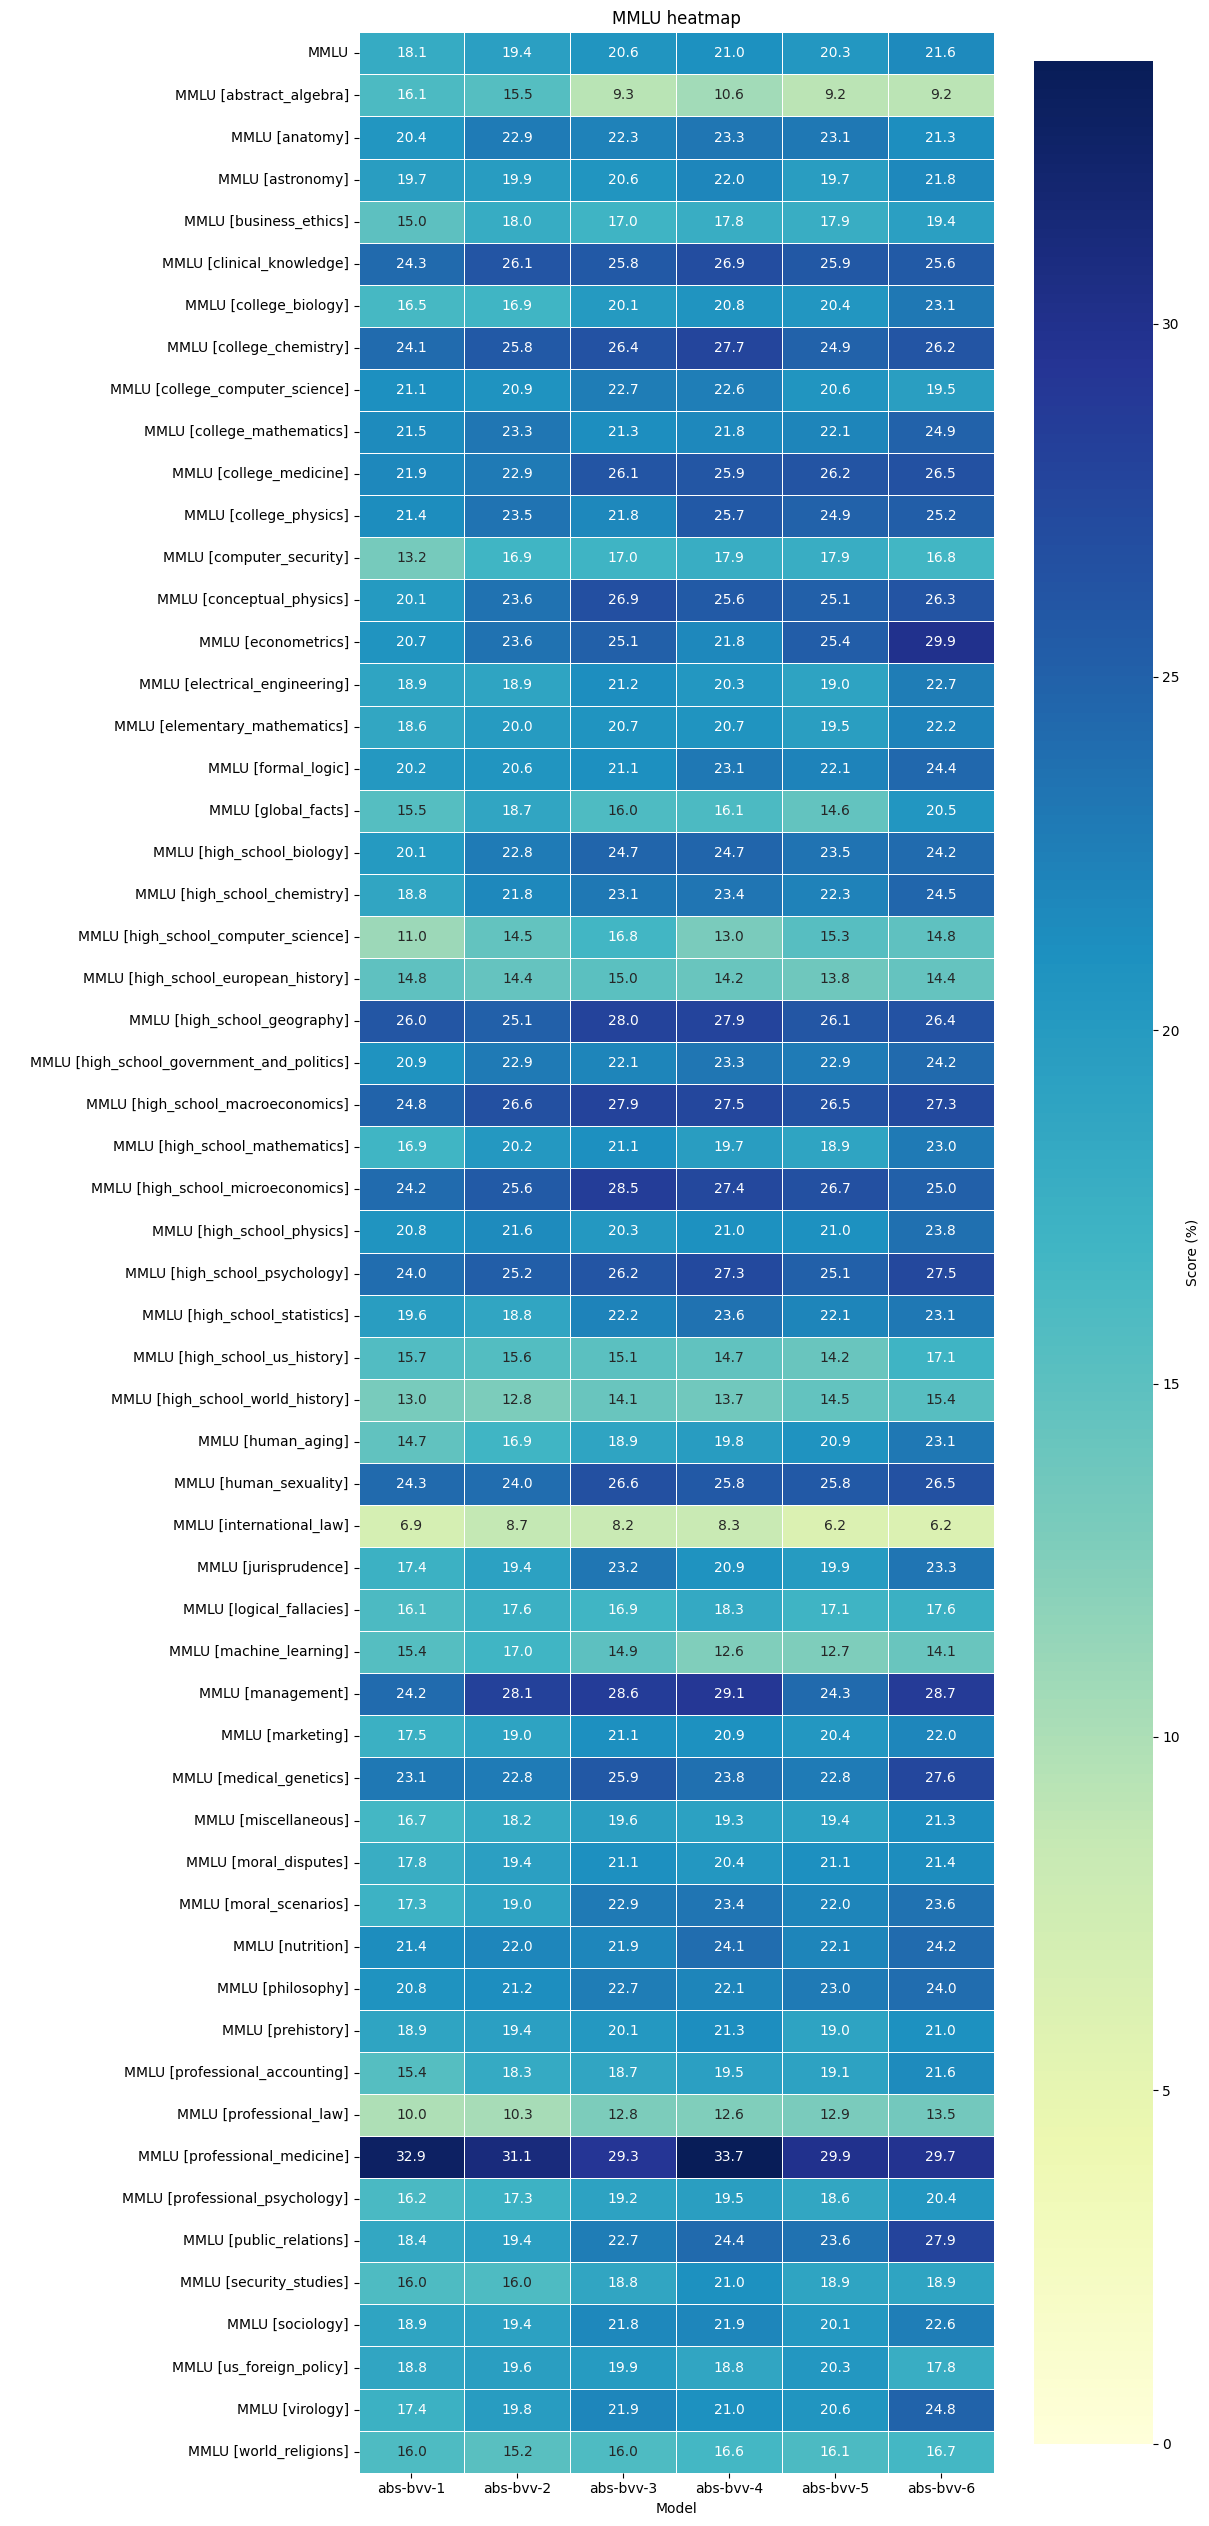

In [10]:
plot_heatmap(df, benchmark_startswith='MMLU')

In [11]:
def plot_heatmap_best_subtasks(df, score_threshold=26.0):
    # Группируем по [benchmark, model], берём максимальный score по модели (на самом деле по файлу у тебя одна строка на пару model+subtask)
    pivot = df.pivot(index='benchmark', columns='model', values='score')
    # Фильтруем: выбрать те строки, где максимальное значение по строке превышает threshold
    high_score_rows = pivot[pivot.max(axis=1) > score_threshold]
    if high_score_rows.empty:
        print(f"Нет задач, где хотя бы одна модель >{score_threshold}%")
        return
    plt.figure(figsize=(1+1.8*len(high_score_rows.columns), 1+0.42*len(high_score_rows)))
    sns.heatmap(high_score_rows, annot=True, fmt=".1f", cmap='YlGnBu', linewidths=0.5,
                cbar_kws=dict(label='Score (%)'), vmin=0, vmax=np.nanmax(high_score_rows.values))
    plt.title(f"Best results >{score_threshold}%")
    plt.ylabel(" ")#plt.ylabel("Benchmark [Task]")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

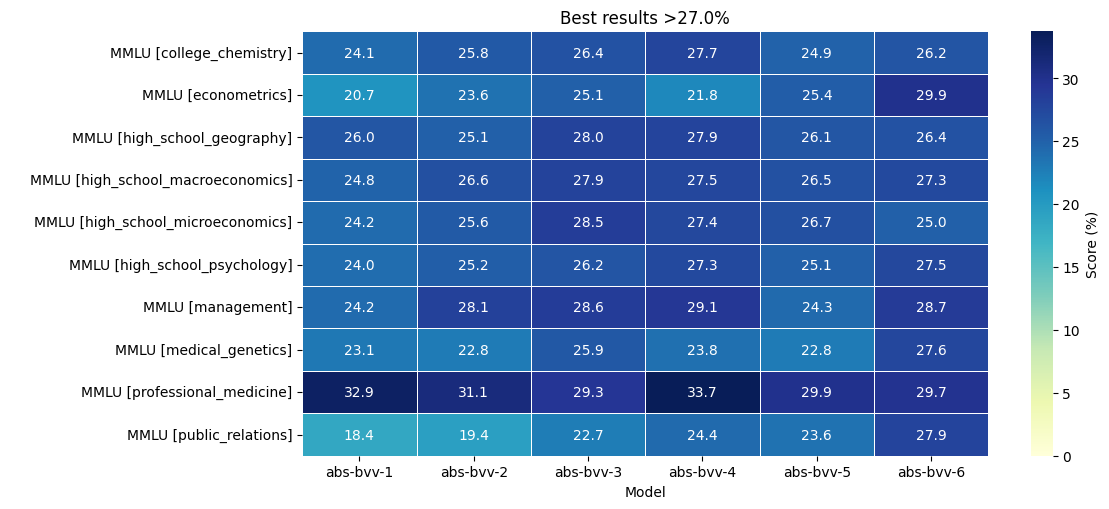

In [12]:
plot_heatmap_best_subtasks(df, score_threshold=27.0)

In [13]:
def print_table_best_subtasks(df, score_threshold=27.0):
    """
    Вывести таблицу (текстом), где максимальный score по хотя бы одной модели > threshold
    """
    import pandas as pd
    # Группировка и получение таблицы
    pivot = df.pivot(index='benchmark', columns='model', values='score')
    high_score_rows = pivot[pivot.max(axis=1) > score_threshold]
    if high_score_rows.empty:
        print(f"Нет задач, где хотя бы одна модель >{score_threshold}%")
        return
    
    # Форматируем значения до 1 знака после запятой (как на heatmap)
    formatted = high_score_rows.applymap(lambda x: f"{x:.1f}" if pd.notnull(x) else "")
    
    #try:
    #    from tabulate import tabulate
    #    print("Таблица лучших результатов (> {:.1f}%):".format(score_threshold))
    #    print(tabulate(formatted, headers='keys', tablefmt='pretty'))
    #except ImportError:
    #    print("tabulate не установлен, вот обычный вывод Pandas:")
        
    print(formatted.to_string())

In [14]:
print_table_best_subtasks(df, score_threshold=27.0)

model                             abs-bvv-1 abs-bvv-2 abs-bvv-3 abs-bvv-4 abs-bvv-5 abs-bvv-6
benchmark                                                                                    
MMLU [college_chemistry]               24.1      25.8      26.4      27.7      24.9      26.2
MMLU [econometrics]                    20.7      23.6      25.1      21.8      25.4      29.9
MMLU [high_school_geography]           26.0      25.1      28.0      27.9      26.1      26.4
MMLU [high_school_macroeconomics]      24.8      26.6      27.9      27.5      26.5      27.3
MMLU [high_school_microeconomics]      24.2      25.6      28.5      27.4      26.7      25.0
MMLU [high_school_psychology]          24.0      25.2      26.2      27.3      25.1      27.5
MMLU [management]                      24.2      28.1      28.6      29.1      24.3      28.7
MMLU [medical_genetics]                23.1      22.8      25.9      23.8      22.8      27.6
MMLU [professional_medicine]           32.9      31.1      2

/tmp/ipykernel_2166158/3970745291.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted = high_score_rows.applymap(lambda x: f"{x:.1f}" if pd.notnull(x) else "")


In [15]:
def get_overview_table(df):
    # Если нужно включить и BLEU, и любые другие "групповые" метрики:
    mask = (~df['benchmark'].str.contains(r'^MMLU \[')) & (~df['benchmark'].str.startswith("BLEU"))
    overview = df[mask].copy()
    overview = overview.sort_values(['benchmark', 'model'])
    return overview
    
overview = get_overview_table(df)

In [16]:
def plot_overview_heatmap(overview):
    table = overview.pivot(index='benchmark', columns='model', values='score')
    plt.figure(figsize=(1+1.8*len(table.columns), 1+0.60*len(table)))
    sns.heatmap(table, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5,
                cbar_kws=dict(label='Score (%)'), vmin=0, vmax=np.nanmax(table.values))
    plt.title("Benchmark by model")
    plt.ylabel(" ")#"Benchmark!"
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

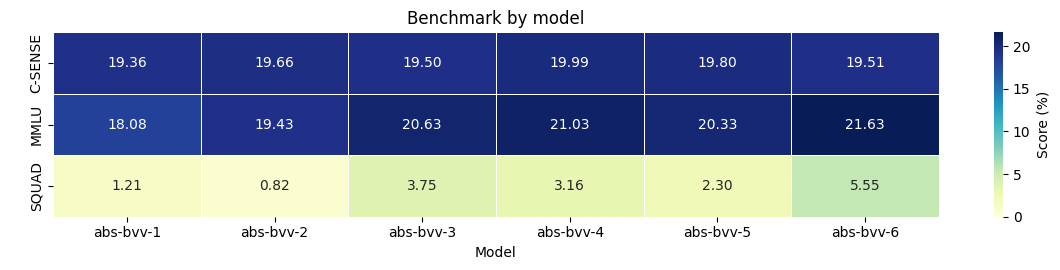

In [17]:
plot_overview_heatmap(overview)

In [18]:
def print_overview_table(overview):
    """
    Вывести текстовую таблицу (без heatmap), аналогичную overview heatmap.
    """
    import pandas as pd
    # Формируем таблицу, как в heatmap
    table = overview.pivot(index='benchmark', columns='model', values='score')
    # Форматируем значения до 2 знаков после запятой (как на heatmap)
    formatted = table.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")
    
    try:
        from tabulate import tabulate
        print("Benchmark by model:")
        print(tabulate(formatted, headers='keys', tablefmt='pretty'))
    except ImportError:
        print("tabulate не установлен, вот обычный вывод Pandas:")
        print(formatted.to_string())

In [19]:
print_overview_table(overview)

Benchmark by model:
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| benchmark | abs-bvv-1 | abs-bvv-2 | abs-bvv-3 | abs-bvv-4 | abs-bvv-5 | abs-bvv-6 |
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|  C-SENSE  |   19.36   |   19.66   |   19.50   |   19.99   |   19.80   |   19.51   |
|   MMLU    |   18.08   |   19.43   |   20.63   |   21.03   |   20.33   |   21.63   |
|   SQUAD   |   1.21    |   0.82    |   3.75    |   3.16    |   2.30    |   5.55    |
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+


/tmp/ipykernel_2166158/1875485470.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted = table.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")
